In [89]:
#!conda run -n ssl python -m spacy download en_core_web_sm

In [90]:
import warnings
import datasets
from collections import Counter, defaultdict
import numpy as np
import random
import pandas as pd
import ast
from itertools import groupby
from typing import List, Dict, Tuple, Union
import copy
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets
import math
import matplotlib.pyplot as plt
import copy
import torch
import code
import seaborn as sns
import pickle
import os
import re
import spacy

nlp = spacy.load('en_core_web_sm')

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

warnings.filterwarnings("ignore")
datasets.logging.set_verbosity_error()
print("Datasets library version: ", datasets.__version__)

Datasets library version:  2.10.1


In [73]:
'''
import zipfile

# Specify the path of the zip file to extract
zip_file_path = 'SSL_finetuned_on_TweetNER.zip'

# Create a ZipFile object
zip_obj = zipfile.ZipFile(zip_file_path)

# Extract all the contents of the zip file to the specified directory
zip_obj.extractall()

# Close the ZipFile object
zip_obj.close()
'''
'''
import zipfile

# Specify the path of the zip file to extract
zip_file_path = 'questions.zip'

# Create a ZipFile object
zip_obj = zipfile.ZipFile(zip_file_path)

# Extract all the contents of the zip file to the specified directory
zip_obj.extractall()

# Close the ZipFile object
zip_obj.close()
'''

"\nimport zipfile\n\n# Specify the path of the zip file to extract\nzip_file_path = 'questions.zip'\n\n# Create a ZipFile object\nzip_obj = zipfile.ZipFile(zip_file_path)\n\n# Extract all the contents of the zip file to the specified directory\nzip_obj.extractall()\n\n# Close the ZipFile object\nzip_obj.close()\n"

In [3]:
pickle_file_name = 'my_pickle_file.pkl'
# Open the pickle file in read mode
with open(pickle_file_name, 'rb') as f:
    # Load the serialized data from the file using pickle.load()
    jeopardy_data = pickle.load(f)
print("Length of read jeopardy data: {}\n".format(len(jeopardy_data)))

Length of read jeopardy data: 1838



In [9]:
conll_label_list = ['O', 'PER', 'ORG', 'LOC', 'MISC']
conll_id2label = {'0': 'O', '1': 'PER', '2': 'ORG', '3': 'LOC', '4': 'MISC'}
conll_label2id = {'O': '0', 'PER': '1', 'ORG': '2', 'LOC': '3', 'MISC': '4'}

In [10]:
from transformers import AutoTokenizer
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = 'SSL_Twitter_final' #'SSL_classifier'#'microsoft/deberta-v3-base' 
BATCH_SIZE = 16
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

label_all_tokens = False

def tokenize_and_align_labels(examples):
    #print("Examples: {}\n".format(examples))
    #tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, max_length=256)
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    #print("Tokenized inputs: {}\n".format(tokenized_inputs))
    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        #print("i: {} and label: {}\n".format(i, label))
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        #print("word ids: {}\n".format(word_ids))
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                #if word_idx is not None and word_idx >= len(label):
                #  word_idx = len(label) - 1
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
              #if word_idx is not None and word_idx >= len(label):
              #  word_idx = len(label) - 1               
              label_ids.append(label[word_idx] if label_all_tokens else -100)
            
            previous_word_idx = word_idx
            #print("current label ids: {}\n".format(label_ids))

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# apply this method on jeopardy documents and questions to make it compatible for NER tagging
def fix_jeopardy_data(data):
  new_data = []
  for i in range(len(data)):
    data_i = data[i]
    new_data_example = {}
    # for every document we keep only the top-5000 tokens
    tokens = data_i['tokens'][:7000]
    '''
    if len(tokens) > 10000:
      continue
    '''
    
    # initially assign ner_tags_str a value of all O's
    ner_tags_str = ['O' for i in range(len(tokens))]
    # intially assign ner_tags a value of of all 0'a
    ner_tags = [0 for i in range(len(tokens))]
    #ner_tags = [int(conll_label2id[ner_tag_str]) for ner_tag_str in ner_tags_str]
    assert len(tokens) == len(ner_tags_str)

    new_data_example['tokens'] = tokens
    new_data_example['ner_tags_str'] = ner_tags_str
    new_data_example['ner_tags'] = ner_tags
    new_data.append(new_data_example)
  
  new_data = datasets.Dataset.from_pandas(pd.DataFrame(data=new_data))
  return new_data

In [11]:
new_jeopardy_data = fix_jeopardy_data(jeopardy_data)
single_jeopardy_example = new_jeopardy_data[0]
#print(single_jeopardy_example['ner_tags'], single_jeopardy_example['ner_tags_str'])
assert len(single_jeopardy_example['ner_tags']) == len(single_jeopardy_example['ner_tags_str'])
assert len(single_jeopardy_example['ner_tags_str']) == len(single_jeopardy_example['tokens'])

In [12]:
print("Final result after token-label alignment: {}\n".format(tokenize_and_align_labels(new_jeopardy_data[2:3])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Final result after token-label alignment: {'input_ids': [[1, 2509, 1812, 27066, 2835, 813, 3988, 1513, 27066, 2835, 813, 3918, 2458, 268, 27066, 2835, 813, 1524, 268, 27066, 2835, 813, 2285, 21126, 1191, 553, 27066, 5550, 4522, 2835, 813, 7466, 3163, 1191, 553, 326, 1248, 2835, 813, 2835, 553, 487, 267, 47808, 2835, 813, 1750, 267, 47808, 2835, 813, 293, 6305, 2011, 14974, 282, 865, 29512, 282, 266, 27066, 5550, 4522, 2835, 813, 272, 925, 277, 2285, 21126, 292, 62368, 456, 1812, 264, 55330, 621, 1513, 1941, 13823, 17316, 2119, 1650, 278, 282, 4396, 661, 469, 661, 2285, 21126, 29165, 353, 813, 3022, 12413, 263, 282, 865, 29512, 1941, 13823, 676, 293, 33770, 452, 4892, 608, 698, 262, 813, 282, 3259, 5143, 293, 262, 2285, 21126, 283, 262, 2029, 304, 282, 961, 24423, 282, 865, 29512, 416, 3988, 267, 1812, 8947, 547, 30492, 13823, 3359, 44304, 321, 265, 43086, 293, 2285, 21126, 295, 12670, 984, 506, 47756, 1460, 1817, 278, 282, 1750, 293, 6305, 2011, 14974, 263, 8561, 7386, 293, 89359, 3187

In [13]:
print("Final result after token-label alignment: {}\n".format(tokenize_and_align_labels(new_jeopardy_data[0:1])))

Final result after token-label alignment: {'input_ids': [[1, 2509, 23680, 608, 262, 16607, 83156, 1470, 10105, 8277, 813, 1470, 12967, 1470, 4506, 267, 3967, 12967, 13247, 355, 12967, 10123, 12967, 355, 292, 27947, 12967, 1094, 15300, 12967, 16607, 13730, 12967, 14909, 13730, 12967, 1034, 265, 3002, 1846, 12967, 11905, 264, 262, 9074, 1603, 301, 15436, 32480, 1803, 1764, 44339, 6074, 327, 6590, 32480, 1803, 1764, 710, 263, 32480, 1803, 5720, 710, 282, 266, 12967, 1470, 676, 293, 19773, 268, 268, 22508, 569, 935, 270, 262, 2835, 813, 23680, 608, 262, 16607, 83156, 263, 10105, 612, 293, 51857, 1890, 718, 13920, 1580, 301, 15436, 362, 1823, 267, 2639, 2861, 265, 23680, 608, 268, 883, 709, 267, 3967, 416, 825, 360, 264, 5465, 442, 813, 10105, 399, 313, 638, 263, 1809, 266, 872, 1470, 270, 773, 709, 1111, 10105, 1061, 709, 262, 1470, 1550, 697, 282, 959, 267, 262, 2097, 32045, 5846, 550, 813, 10105, 385, 262, 1394, 301, 15436, 282, 4506, 283, 266, 1034, 265, 262, 66986, 3970, 299, 1416, 319

In [14]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
data_collator = DataCollatorForTokenClassification(tokenizer)

In [15]:
new_jeopardy_data.column_names

['tokens', 'ner_tags_str', 'ner_tags']

In [16]:
tokenized_jeopardy = new_jeopardy_data.map(tokenize_and_align_labels, batched=True, remove_columns=new_jeopardy_data.column_names, load_from_cache_file=False)

Map:   0%|          | 0/1838 [00:00<?, ? examples/s]

In [17]:
jeopardy_dataloader = DataLoader(tokenized_jeopardy, collate_fn=data_collator, batch_size=1)

In [18]:
model_name = model_checkpoint
print(model_name)

SSL_Twitter_final


In [19]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained('SSL_Twitter_final', id2label=conll_id2label, label2id=conll_label2id)
model.cuda()

DebertaV2ForTokenClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=Tr

In [20]:
device = torch.device("cuda") 
print(device)
model = model.to(device)
print(next(model.parameters()).is_cuda) # returns a boolean

cuda
True


In [21]:
from tqdm import tqdm

In [22]:
ner_tagged_jeopardy_dataset = []

for i, batch in tqdm(enumerate(jeopardy_dataloader)):

  #print(batch)
  #batch = tuple(batch[t] for t in batch)
  batch = tuple(batch[t].to(device) for t in batch)
  b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch

  #print(len(b_input_ids[0]))
  #print("For i = {}\n, tokens = {}\n, ner_tags_str = {}\n".format(i, new_jeopardy_data[i]['tokens'], 
  #                                                                new_jeopardy_data[i]['ner_tags_str']))
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  predictions = outputs.logits.argmax(dim=-1)
  #print(predictions)
  true_predictions = [[conll_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, b_labels)]
  

  # update ner_tags_str of this example
  ner_tagged_jeopardy_sample = {}
  ner_tagged_jeopardy_sample['tokens'] = new_jeopardy_data[i]['tokens']
  ner_tagged_jeopardy_sample['ner_tags_str'] = true_predictions[0]
  #print(len(true_predictions[0]), len(new_jeopardy_data[i]['tokens']))
  assert len(true_predictions[0]) == len(new_jeopardy_data[i]['tokens'])
  ner_tagged_jeopardy_dataset.append(ner_tagged_jeopardy_sample)
  #print("predictions = {}\n".format(true_predictions[0]))
  #break

0it [00:00, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
1838it [17:39,  1.73it/s]


In [23]:
count = 0
for i in range(len(jeopardy_data)):
    if len(jeopardy_data[i]['tokens']) > 7000:
        count += 1
print(count)

343


In [24]:
'''
with open('ner_tagged_jeopardy_dataset.pickle', 'wb') as f:
    pickle.dump(ner_tagged_jeopardy_dataset, f)
'''

In [25]:
with open('ner_tagged_jeopardy_dataset.pickle', 'rb') as f:
    ner_tagged_jeopardy_dataset = pickle.load(f)

In [26]:
ner_tagged_jeopardy_dataset[0]['ner_tags_str']

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O'

In [27]:
sentences_tagged = 0
for i in range(len(ner_tagged_jeopardy_dataset)):
    ner_tags_str = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
    for j in range(len(ner_tags_str)):
        if ner_tags_str[j] != 'O':
            sentences_tagged += 1
            break
print(sentences_tagged)

1241


In [28]:
len(ner_tagged_jeopardy_dataset)

1838

In [29]:
counts_docs = defaultdict(int)

for i in range(len(ner_tagged_jeopardy_dataset)):
  ner_tags = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
  for j in range(len(ner_tags)):
    counts_docs[ner_tags[j]] += 1

<Axes: xlabel='ner_tag', ylabel='count'>

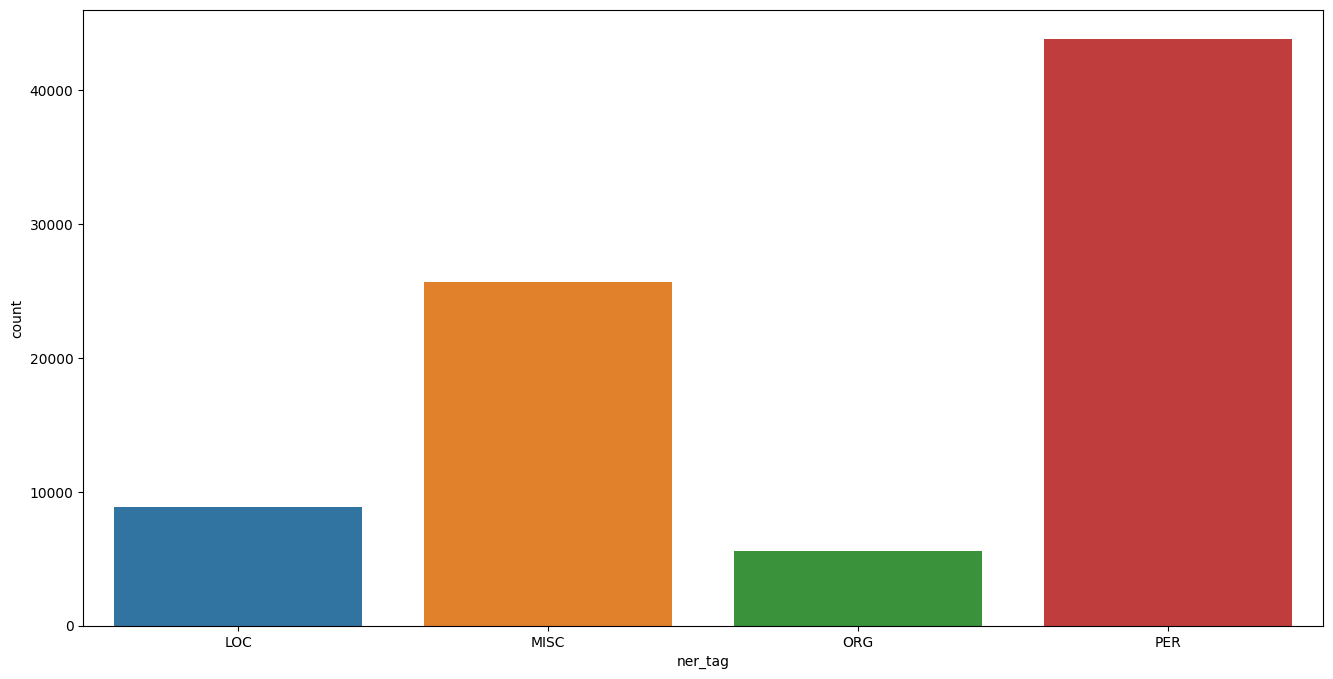

In [30]:
data = [{'ner_tag': k, 'count': v} for (k, v) in counts_docs.items()]
df = pd.DataFrame(data)
df = df.sort_values(by=['ner_tag'])
sns.barplot(data=df[df['ner_tag'] != 'O'], x='ner_tag', y='count')

In [31]:
for i in range(len(ner_tagged_jeopardy_dataset)):
  ner_tags_str = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
  count = 0
  tag_found = False
  for j in range(len(ner_tags_str)):
    if ner_tags_str[j] != 'O':
      count += 1
      tag_found = True
  if tag_found:
    print("count of NE's in documents {} given doc length {}".format(count, len(ner_tags_str)))

count of NE's in documents 13 given doc length 4107
count of NE's in documents 32 given doc length 3027
count of NE's in documents 66 given doc length 2555
count of NE's in documents 58 given doc length 2428
count of NE's in documents 165 given doc length 1772
count of NE's in documents 163 given doc length 1162
count of NE's in documents 133 given doc length 2263
count of NE's in documents 31 given doc length 2677
count of NE's in documents 144 given doc length 2466
count of NE's in documents 48 given doc length 2574
count of NE's in documents 288 given doc length 1072
count of NE's in documents 123 given doc length 1828
count of NE's in documents 69 given doc length 2163
count of NE's in documents 324 given doc length 773
count of NE's in documents 1 given doc length 4559
count of NE's in documents 63 given doc length 3154
count of NE's in documents 92 given doc length 1336
count of NE's in documents 103 given doc length 1241
count of NE's in documents 101 given doc length 524
count 

count of NE's in documents 12 given doc length 3810
count of NE's in documents 103 given doc length 1490
count of NE's in documents 93 given doc length 995
count of NE's in documents 2 given doc length 6436
count of NE's in documents 112 given doc length 1372
count of NE's in documents 103 given doc length 1978
count of NE's in documents 45 given doc length 1743
count of NE's in documents 4 given doc length 3538
count of NE's in documents 187 given doc length 1239
count of NE's in documents 52 given doc length 1576
count of NE's in documents 19 given doc length 3024
count of NE's in documents 174 given doc length 1075
count of NE's in documents 74 given doc length 2200
count of NE's in documents 94 given doc length 2038
count of NE's in documents 25 given doc length 2586
count of NE's in documents 407 given doc length 887
count of NE's in documents 140 given doc length 1586
count of NE's in documents 33 given doc length 1949
count of NE's in documents 37 given doc length 320
count of N

count of NE's in documents 3 given doc length 4808
count of NE's in documents 152 given doc length 2049
count of NE's in documents 3 given doc length 5366
count of NE's in documents 165 given doc length 775
count of NE's in documents 11 given doc length 3564
count of NE's in documents 176 given doc length 1069
count of NE's in documents 13 given doc length 4293
count of NE's in documents 130 given doc length 1209
count of NE's in documents 111 given doc length 792
count of NE's in documents 216 given doc length 799
count of NE's in documents 24 given doc length 3894
count of NE's in documents 5 given doc length 2662
count of NE's in documents 31 given doc length 1672
count of NE's in documents 54 given doc length 2518
count of NE's in documents 40 given doc length 733
count of NE's in documents 58 given doc length 1489
count of NE's in documents 182 given doc length 1392
count of NE's in documents 137 given doc length 493
count of NE's in documents 1 given doc length 3647
count of NE's

In [34]:
with open('ner_tagged_question_dataset.pickle', 'rb') as f:
    ner_tagged_question_dataset = pickle.load(f)

## EntityTFIDF implementation

### Helper functions

In [35]:
def extract_NE(input_str):
    return input_str.split('_')[1]

In [114]:
DF = {} # for each token of a specific entity type, store its document frequency
for i in range(len(ner_tagged_jeopardy_dataset)):
    tokens = ner_tagged_jeopardy_dataset[i]['tokens']
    ner_tags_str = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
    for w in range(len(tokens)):
        # extra condition: only consider non-O tokens
        if ner_tags_str[w] == 'O':
            continue
        token_to_add = tokens[w] + '_' + ner_tags_str[w]
        try:
            DF[token_to_add].add(i)
        except:
            DF[token_to_add] = {i}

for term in DF:
    DF[term] = len(DF[term])

total_vocab = [x for x in DF]

#print(total_vocab)

# calculate the term frequency of each term in each document for all documents
tf_scores_all_docs = [] # a list of dicts
for i in range(len(ner_tagged_jeopardy_dataset)):
    tf_score_per_doc = {}
    tokens = ner_tagged_jeopardy_dataset[i]['tokens']
    ner_tags_str = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
    # make a tokens to consider list where each token has its NE label added to it by a '_'
    #tokens_to_consider = [tokens[w] + '_' + ner_tags_str[w] for w in range(len(tokens))]
    # extra condition: only consider non-O tokens
    tokens_to_consider = [tokens[w] + '_' + ner_tags_str[w] for w in range(len(tokens)) if ner_tags_str[w] != 'O']
    #print(tokens_to_consider)
    # calculate term frequency based on entity type
    for x in range(len(tokens_to_consider)):
        tf_score_per_doc[tokens_to_consider[x]] = 1 + math.log10(Counter(tokens_to_consider)[tokens_to_consider[x]])
    
    tf_scores_all_docs.append(tf_score_per_doc)
    # just for 1 doc first
    #break


# calculate the TF-IDF scores for each term in each documents for all documents
tfidf_scores_all_docs = [] # a list of dicts
for i in range(len(ner_tagged_jeopardy_dataset)):
    tf_idf_score_per_doc = {}
    for term, tf in tf_scores_all_docs[i].items():
        # idf of this term with this tf in document_i onlu
        idf = math.log(len(ner_tagged_jeopardy_dataset) / DF[term]+1)
        tf_idf_score_per_doc[term] = tf * idf
    
    tfidf_scores_all_docs.append(tf_idf_score_per_doc)
    # just for 1 doc first
    #break

    

### Save EntityTDIDF scores list

In [98]:
'''
with open('entity_tfidf_scores_all_docs', 'wb') as f:
    pickle.dump(tfidf_scores_all_docs, f)
'''

### Load EntityTFIDF scores list

In [122]:
with open('entity_tfidf_scores_all_docs', 'rb') as f:
    tfidf_scores_all_docs = pickle.load(f)

In [123]:
len(tfidf_scores_all_docs)

1838

In [124]:
'''
    Procedure: compute matching of query with document i -> use tfidf_scores_all_docs[i] 
    to get all the scores for each term in doc_i
    
    Check which of your query terms are in the keys of tfidf_scores_all_docs[i]
    
    get the scores for just those terms only
    
    sum'em up to get the final rank for that document only

'''

''' Returns the matching score for doc i '''
def matching_score(tfidf_scores_all_docs, question_tokens, question_ner_tags, i):
    question_doc_i_score = 0.0 # score of question w.r.t doc_i
    question_tokens_to_consider = [question_tokens[q] + '_' + question_ner_tags[q] for q in range(len(question_tokens))]
    for qtc in question_tokens_to_consider:
        if qtc in tfidf_scores_all_docs[i]:
            question_doc_i_score += tfidf_scores_all_docs[i][qtc]
    return question_doc_i_score

### Some code to get the gold answers for each question

In [125]:
path_name = "questions.txt"

questions = []
answers = []

with open(path_name, "r", encoding="utf8") as f:
    # Initialize variables
    objects = []
    current_obj = {}

    # Loop over each line in the file
    for line in f:
        # Strip any whitespace and skip empty lines
        line = line.strip()
        if not line:
            continue

        # Check if this line is a category
        if not current_obj:
            current_obj["category"] = line
        else:
            # Add the question or answer to the current object
            if "question" not in current_obj:
                current_obj["question"] = line
                questions.append(line)
            else:
                current_obj["answer"] = line
                answers.append(line)
                # Add the current object to the list and reset it
                objects.append(current_obj)
                current_obj = {}

    # Add the last object to the list
    if current_obj:
        objects.append(current_obj)

# Define a regular expression pattern to match non-alphabetic characters
pattern = re.compile(r'[^a-zA-Z0-9 ]+')
questions_lemmatized = []
for question in questions:
  doc = nlp(question)
  lemmatized_tokens = ' '.join([token.lemma_ for token in doc])
  lemmatized_tokens = re.sub(pattern, ' ', lemmatized_tokens)
  lemmatized_tokens = ' '.join(lemmatized_tokens.split()).lower()
  questions_lemmatized.append(lemmatized_tokens)

print("Length of questions lemmatized: {}\n".format(len(questions_lemmatized)))

from collections import defaultdict
q_to_ans = defaultdict(list)

def answer_lemmatizer(answer):
  pattern = re.compile(r'[^a-zA-Z0-9 ]+')
  lemmatized_ans = re.sub(pattern, ' ', answer)
  lemmatized_ans = ' '.join(lemmatized_ans.split()).lower()
  return lemmatized_ans

for i in range(len(questions_lemmatized)):
  answer = answers[i]
  # if there is a '|' in answer, break it into sub answers and add them to the defaultdict
  if '|' in answer:
    sub_answer_tokens = answer.split('|')
    for token in sub_answer_tokens:
      q_to_ans[questions_lemmatized[i]].append(answer_lemmatizer(token))
  else:
      q_to_ans[questions_lemmatized[i]].append(answer_lemmatizer(answer))
    
print("Length of questions_lemmatized_to_answers: {}\n".format(len(q_to_ans)))

print("questions_lemmatized_to_answers dict: {}\n".format(q_to_ans))

answers_fixed = []
for answer in answers:
  if '|' in answer:
    sub_answer_tokens = answer.split('|')
    for token in sub_answer_tokens:
      answers_fixed.append(token)
  else:
    answers_fixed.append(answer)

print("Length of answers fixed: {}\n".format(len(answers_fixed)))

pattern = re.compile(r'[^a-zA-Z0-9 ]+')
answers_lemmatized = []
for answer in answers_fixed:
  lemmatized_ans = re.sub(pattern, ' ', answer)
  lemmatized_ans = ' '.join(lemmatized_ans.split()).lower()
  answers_lemmatized.append(lemmatized_ans)

print("Length of answers lemmatized: {}\n".format(len(answers_lemmatized)))

Length of questions lemmatized: 100

Length of questions_lemmatized_to_answers: 100

questions_lemmatized_to_answers dict: defaultdict(<class 'list'>, {'the dominant paper in our nation s capital it be among the top 10 u s paper in circulation': ['the washington post'], 'the practice of pre authorizing presidential use of force date to a 1955 resolution re this island near mainland china': ['taiwan'], 'daniel hertzberg james b stewart of this paper share a 1988 pulitzer for their story about insider trading': ['the wall street journal'], 'song that say you make i smile with my heart your look be laughable unphotographable': ['my funny valentine'], 'in 2011 bell ringer for this charity start accept digital donation to its red kettle': ['the salvation army', 'salvation army'], 'the naples museum of art': ['florida'], 'this italian painter depict the adoration of the golden calf': ['tintoretto'], 'this woman who win consecutive heptathlon at the olympics go to ucla on a basketball scholar

In [126]:
print(len(jeopardy_data), len(questions_lemmatized), len(answers_fixed), len(answers_lemmatized), 
      len(q_to_ans)) # sanity check

1838 100 115 115 100


In [127]:
sum_reciprocal_ranks = 0
for i in range(1, len(ner_tagged_question_dataset)+1):
    question_tokens = ner_tagged_question_dataset[i-1]['tokens']
    question_ner_tags = ner_tagged_question_dataset[i-1]['ner_tags_str']
    cand_answers_for_question_i = [] # stores document title/ans and document score for each ans to question_i
    for j in range(len(ner_tagged_jeopardy_dataset)):
        # compute the score of question_i with doc_j 
        score_question_i_doc_j = matching_score(tfidf_scores_all_docs, question_tokens, question_ner_tags, j)
        #print(score_question_i_doc_j)
        cand_answers_for_question_i.append((jeopardy_data[j]['title'], score_question_i_doc_j))
        #break
    # sort answers in descending order
    cand_answers_for_question_i_ranked = sorted(cand_answers_for_question_i, key=lambda x: x[1], reverse=True)
    cand_answer_only_for_question_i_ranked = [t[0] for t in cand_answers_for_question_i_ranked]
    print("For question: {}\n".format(' '.join(question_tokens)))
    print("with NER tags: {}\n".format(' '.join(question_ner_tags)))
    print("and gold answer: {}\n".format(q_to_ans[questions_lemmatized[i-1]]))
    print("Candidate answers:\n{}\n".format(cand_answer_only_for_question_i_ranked[:20]))
    # MRR score calculation for Entity_TFIDF
    rank = 0
    for k in range(len(cand_answers_for_question_i_ranked)):
        if cand_answers_for_question_i_ranked[k][0] in q_to_ans[questions_lemmatized[i-1]]:
            rank = k+1
            break
    # Calculate the reciprocal rank
    if rank != 0:
        reciprocal_rank = 1.0 / rank
    else:
        reciprocal_rank = 0.0
    
    sum_reciprocal_ranks += reciprocal_rank
    #break
MRR = sum_reciprocal_ranks/len(questions_lemmatized)
print("MRR for EntityTFIDF: {}\n".format(MRR))

For question: the dominant paper in our nation s capital it be among the top 10 u s paper in circulation

with NER tags: O O O O O O O O O O O O O O O O O O O

and gold answer: ['the washington post']

Candidate answers:
['william randolph hearst', 'the wall street journal', 'the washington post', 'the spectator', 'deflation', 'houston chronicle', 'new york post', 'the new york sun', 'media of the united states', 'los angeles times', 'henry kissinger', 'china united states relations', 'yellow journalism', 'helsinki', 'cbs', 'saint gaudens double eagle', 'kansas city missouri', 'jefferson davis', 'madison wisconsin', 'muslim brotherhood']

For question: the practice of pre authorizing presidential use of force date to a 1955 resolution re this island near mainland china

with NER tags: O O O O O O O O O O O O O O O O LOC O LOC LOC

and gold answer: ['taiwan']

Candidate answers:
['united nations general assembly resolution 505', 'lockheed u 2', 'nancy pelosi', 'lin sen', 'dennis kucinic

For question: in 1980 china found a center for these cute creature in its bamboo rich wolong nature preserve

with NER tags: O O LOC O O O O O O O O O O O O O O

and gold answer: ['panda', 'giant panda']

Candidate answers:
['chengdu', 'chinese music', 'tourism in india', 'chinese american', 'leopard', 'museum', 'list of madagascar franchise characters', 'list of star control races', 'florida museum of natural history', 'michael crichton', 'history of italy', 'fauna of australia', 'la venta', 'havana', 'asparagus', 'kubla khan', 'silk in the indian subcontinent', 'san salvador', 'omaha nebraska', 'porto alegre']

For question: 1988 father figure

with NER tags: O O O

and gold answer: ['george michael']

Candidate answers:
['edgar degas', 'ozzie smith', 'joe biden', 'john le mesurier', 'coronation street', 'ondine novel', 'marsyas', 'sarah winnemucca', 'jesse jackson', 'wayang', 'gertrude stein', 'wandering jew', 'sigurd stones', 'nancy reagan', 'oscar wilde', 'list of doctor who villa

For question: france s philip iv know as the fair had jacques de molay the last grand master of this order burn in 1314

with NER tags: LOC O O O O O O O O O O O O O O O O O O O O O

and gold answer: ['knights templar']

Candidate answers:
['knights templar', 'philip iv of france', 'paris', 'history of france', 'philip v of france', 'louis xiv of france', 'charles ii of navarre', 'philip iv of spain', 'avignon papacy', 'diego vel zquez', 'house of habsburg', '1340s', 'charles iv of france', 'tuileries garden', 'joan of arc', 'house of bourbon', 'louis xiii of france', 'crown jewels', 'valencia', 'ottoman empire']

For question: the georgia o keeffe museum

with NER tags: O ORG ORG ORG ORG

and gold answer: ['new mexico']

Candidate answers:
['roman de salvo', 'marion l brittain', 'jen stark', 'fort james jackson', 'new orleans jazz museum', 'shawn brixey', 'meshes of the afternoon', 'eulabee dix', 'old governor s mansion milledgeville georgia', 'napier s bones', 'history of augusta geo

For question: one of his tales of a wayside inn begin listen my child and you shall hear of the midnight ride of paul revere

with NER tags: O O O O O O LOC LOC O O O O O O O O O O MISC O O PER PER

and gold answer: ['henry wadsworth longfellow']

Candidate answers:
['william dawes', 'john the baptist', 'henry wadsworth longfellow', 'sherlock holmes', 'madama butterfly', 'th r se of lisieux', 's ren kierkegaard', 'maria callas', 'elijah', 'march on washington for jobs and freedom', 'charity play', 'fleeming jenkin', 'roy orbison', 'w b yeats', 'mary magdalene', 'lord byron', 'john mellencamp', 'oscar wilde', 'ramsey campbell', 'keith moon']

For question: this bestseller about problem on the mccain palin ticket become an hbo movie with julianne moore

with NER tags: O O O O O O MISC MISC O O O O MISC O PER PER

and gold answer: ['game change']

Candidate answers:
['game change', 'rosie o donnell', 'true blood', 'equal rights amendment', 'michael crichton', 'michael moore', 'vice presid

For question: italian for leader it be especially apply to benito mussolini

with NER tags: O O O O O O O O PER PER

and gold answer: ['duce']

Candidate answers:
['duce', 'carlo tresca', 'romano mussolini', 'esercito nazionale repubblicano', 'luigi barzini jr', 'foreign relations of italy', 'fascism in europe', 'agostino lanzillo', 'alessandra mussolini', 'michele bianchi', 'galeazzo ciano', 'art nouveau', 'cult of personality', 'nazi party', 'italian empire', 'konrad adenauer', 'culture of italy', 'the prince', 'neo fascism', 'pope pius xi']

For question: the kalamazoo institute of arts

with NER tags: O ORG ORG O ORG

and gold answer: ['michigan']

Candidate answers:
['maud le vavasour baroness butler', 'douglas den uyl', 'shalom hartman institute', 'roman de salvo', 'donald margulies', 'kenneth branagh', 'skylar astin', 'tayasal archaeological site', 'power nap', 'bastia', 'ashurbanipal sculpture', 'shawn brixey', 'jen stark', 'raichur district', 'numeral linguistics', 'rocky carr

For question: 1989 miss you much

with NER tags: O O O O

and gold answer: ['janet jackson']

Candidate answers:
['annie musical', 'vivien leigh', 'michelle pfeiffer', 'rita hayworth', 'halle berry', 'gertrude stein', 'romper room', 'bette davis', 'gloria estefan', 'pittsburgh penguins', 'emily dickinson', 'liv tyler', 'ferris bueller s day off', 'michelle shocked', 'kenneth branagh', 'ringo starr', 'carroll o connor', 'river phoenix', 'starlight express', 'sherlock holmes']

For question: 1922 it be the end of an empire this empire in fact after 600 year it be goodbye this hello turkish republic

with NER tags: O O O O O O O O O O O O O O O O O O O O LOC O

and gold answer: ['ottoman empire']

Candidate answers:
['history of modern greece', 'aftermath of world war i', 'russo turkish war 1877 78', 'history of armenia', 'constantinople', 'weimar republic', 'ottoman empire', 'bessarabia', 'history of albania', 'lycia', 'italian empire', 'macedonia region', 'konrad adenauer', 'history of 

In [118]:
for term, tf in tf_scores_all_docs[0].items():
    print(term, tf)
    

abbie_PER 1.0
bernstein_PER 1.0
denisof_PER 1.0
fred_PER 1.6020599913279625
wesley_PER 1.3010299956639813
illyria_PER 1.6020599913279625


In [119]:
for term, tfidf in tfidf_scores_all_docs[0].items():
    print(term, tfidf)

abbie_PER 6.824373670043086
bernstein_PER 6.824373670043086
denisof_PER 7.516977224604321
fred_PER 6.618792681623209
wesley_PER 8.878714846345545
illyria_PER 12.04264846726209


In [120]:
total_vocab

['abbie_PER',
 'bernstein_PER',
 'denisof_PER',
 'fred_PER',
 'wesley_PER',
 'illyria_PER',
 'brien_PER',
 'johnny_PER',
 'white_PER',
 'molly_PER',
 'southern_MISC',
 'decadence_MISC',
 'festival_MISC',
 'labor_MISC',
 'day_MISC',
 'antoine_PER',
 'tujague_PER',
 'galatoire_PER',
 'broussard_PER',
 'brennan_PER',
 'french_MISC',
 'chef_PER',
 'paul_PER',
 'prudhomme_PER',
 'k_PER',
 'emeril_PER',
 'lagasse_PER',
 'john_PER',
 'besh_PER',
 'amed_PER',
 'e_PER',
 'peychaud_PER',
 'monteleone_PER',
 'bruce_PER',
 'thomas_PER',
 'james_PER',
 'york_MISC',
 'new_MISC',
 'new_LOC',
 'york_LOC',
 'michael_PER',
 'bloomberg_PER',
 'sun_MISC',
 'seth_PER',
 'lipsky_PER',
 'mr_PER',
 'cheney_PER',
 'obama_PER',
 'zachary_PER',
 'm_PER',
 'seward_PER',
 'calderone_PER',
 'robert_PER',
 'new_ORG',
 'york_ORG',
 'lawrence_PER',
 'kudlow_PER',
 'lance_PER',
 'esplund_PER',
 'brice_PER',
 'brown_PER',
 'jay_PER',
 'nordlinger_PER',
 'joel_PER',
 'lobenthal_PER',
 'marion_PER',
 'maneker_PER',
 'manh

### Vanilla TFIDF

In [ ]:
DF = {} # for each token of a specific entity type, store its document frequency
for i in range(len(ner_tagged_jeopardy_dataset)):
    tokens = ner_tagged_jeopardy_dataset[i]['tokens']
    ner_tags_str = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
    for w in range(len(tokens)):
        token_to_add = tokens[w]
        try:
            DF[token_to_add].add(i)
        except:
            DF[token_to_add] = {i}

for term in DF:
    DF[term] = len(DF[term])

total_vocab = [x for x in DF]

#print(total_vocab)

# calculate the term frequency of each term in each document for all documents
tf_scores_all_docs = [] # a list of dicts
for i in range(len(ner_tagged_jeopardy_dataset)):
    tf_score_per_doc = {}
    tokens = ner_tagged_jeopardy_dataset[i]['tokens']
    ner_tags_str = ner_tagged_jeopardy_dataset[i]['ner_tags_str']
    # make a tokens to consider list where each token has its NE label added to it by a '_'
    #tokens_to_consider = [tokens[w] + '_' + ner_tags_str[w] for w in range(len(tokens))]
    # extra condition: only consider non-O tokens
    tokens_to_consider = [tokens[w] for w in range(len(tokens))]
    #print(tokens_to_consider)
    # calculate term frequency based on entity type
    for x in range(len(tokens_to_consider)):
        tf_score_per_doc[tokens_to_consider[x]] = 1 + math.log10(Counter(tokens_to_consider)[tokens_to_consider[x]])
    
    tf_scores_all_docs.append(tf_score_per_doc)
    # just for 1 doc first
    #break


# calculate the TF-IDF scores for each term in each documents for all documents
tfidf_scores_all_docs = [] # a list of dicts
for i in range(len(ner_tagged_jeopardy_dataset)):
    tf_idf_score_per_doc = {}
    for term, tf in tf_scores_all_docs[i].items():
        # idf of this term with this tf in document_i onlu
        idf = math.log(len(ner_tagged_jeopardy_dataset) / DF[term]+1)
        tf_idf_score_per_doc[term] = tf * idf
    
    tfidf_scores_all_docs.append(tf_idf_score_per_doc)
    # just for 1 doc first
    #break

    

In [ ]:
''' Returns the matching score for doc i '''
def matching_score(tfidf_scores_all_docs, question_tokens, question_ner_tags, i):
    question_doc_i_score = 0.0 # score of question w.r.t doc_i
    question_tokens_to_consider = [question_tokens[q] for q in range(len(question_tokens))]
    for qtc in question_tokens_to_consider:
        if qtc in tfidf_scores_all_docs[i]:
            question_doc_i_score += tfidf_scores_all_docs[i][qtc]
    return question_doc_i_score

In [ ]:
sum_reciprocal_ranks = 0
for i in range(1, len(ner_tagged_question_dataset)+1):
    question_tokens = ner_tagged_question_dataset[i-1]['tokens']
    question_ner_tags = ner_tagged_question_dataset[i-1]['ner_tags_str']
    cand_answers_for_question_i = [] # stores document title/ans and document score for each ans to question_i
    for j in range(len(ner_tagged_jeopardy_dataset)):
        # compute the score of question_i with doc_j 
        score_question_i_doc_j = matching_score(tfidf_scores_all_docs, question_tokens, question_ner_tags, j)
        #print(score_question_i_doc_j)
        cand_answers_for_question_i.append((jeopardy_data[j]['title'], score_question_i_doc_j))
        #break
    # sort answers in descending order
    cand_answers_for_question_i_ranked = sorted(cand_answers_for_question_i, key=lambda x: x[1], reverse=True)
    cand_answer_only_for_question_i_ranked = [t[0] for t in cand_answers_for_question_i_ranked]
    print("For question: {}\n".format(' '.join(question_tokens)))
    print("and gold answer: {}\n".format(q_to_ans[questions_lemmatized[i-1]]))
    print("Candidate answers:\n{}\n".format(cand_answer_only_for_question_i_ranked[:20]))
    # MRR score calculation for Entity_TFIDF
    rank = 0
    for k in range(len(cand_answers_for_question_i_ranked)):
        if cand_answers_for_question_i_ranked[k][0] in q_to_ans[questions_lemmatized[i-1]]:
            rank = k+1
            break
    # Calculate the reciprocal rank
    if rank != 0:
        reciprocal_rank = 1.0 / rank
    else:
        reciprocal_rank = 0.0
    
    sum_reciprocal_ranks += reciprocal_rank
    #break
MRR = sum_reciprocal_ranks/len(questions_lemmatized)
print("MRR for EntityTFIDF: {}\n".format(MRR))